In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import scipy
from sklearn.decomposition import PCA
from helper_funcs import *

In [2]:
data_latent_vec = np.load('../Data/latent_vecs10.npz') # Load latent representations

In [3]:
list(data_latent_vec.keys())

['salient_vec_abide',
 'background_vec_abide',
 'vae_vec_abide',
 'salient_vec_sfari',
 'background_vec_sfari',
 'vae_vec_sfari']

In [4]:
# Split dictionary into separate variables
salient_vec_abide = data_latent_vec['salient_vec_abide']
background_vec_abide = data_latent_vec['background_vec_abide']
vae_vec_abide = data_latent_vec['vae_vec_abide']
salient_vec_sfari = data_latent_vec['salient_vec_sfari']
background_vec_sfari = data_latent_vec['background_vec_sfari']
vae_vec_sfari = data_latent_vec['vae_vec_sfari']

In [5]:
def data2cmat(data):
    return np.array([squareform(pdist(data[s,:,:],metric='euclidean')) for s in range(data.shape[0])])

In [6]:
# Bar plot function
def plot_nice_bar(key,rsa,ax=None,figsize=None,dpi=None,fontsize=None,fontsize_star=None,fontweight=None,line_width=None,marker_size=None,title=None,report_t=False,do_pairwise_stars=False,do_one_sample_stars=True):
    
    import seaborn as sns
    from scipy.stats import ttest_1samp
    from scipy.stats import ttest_ind as ttest
    
    pallete = sns.color_palette()
    pallete_new = sns.color_palette()
    
    if not figsize:
        figsize = (5,2)
    if not dpi:
        dpi = 300
        
    if not ax:
        fig, ax = plt.subplots(1,1,figsize=figsize,dpi=dpi)

    pallete_new[1]=pallete[0]
    pallete_new[0]=pallete[1]
    pallete_new[0] = tuple(np.array((.5,.5,.5)))

    data=rsa[key]
    n = data.shape[0]
    c = data.shape[1]
    x = np.arange(c)
    
    if not fontsize:
        fontsize = 16
        
    if not fontsize_star:
        fontsize_star = 25
    if not fontweight:        
        fontweight = 'bold'
    if not line_width:    
        line_width = 2.5
    if not marker_size:            
        marker_size = .1
    


    for i in range(c):
        plot_data = np.zeros(data.shape)
        plot_data[:,i] = data[:,i]

        xs = np.repeat(i,n)+(np.random.rand(n)-.5)*.25
        sc = plt.scatter(xs,data[:,i],c='k',s = marker_size)
        b = sns.barplot(data=plot_data,errcolor='r',linewidth=line_width,errwidth=line_width,facecolor=np.hstack((np.array(pallete_new[i]),.3)),edgecolor=np.hstack((np.array(pallete_new[i]),1)))

    locs, labels = plt.yticks()  
    new_y = locs
    new_y = np.linspace(locs[0],locs[-1],6)
    plt.yticks(new_y,labels=[f'{yy:.2f}' for yy in new_y],fontsize=fontsize,fontweight=fontweight)
    plt.ylabel('model fit (r)',fontsize=fontsize,fontweight=fontweight)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)

    for axis in ['top','bottom','left','right']:
            ax.spines[axis].set_linewidth(line_width)

    xlbls = ['VAE','BG','SL']
    plt.xticks(np.arange(3),labels=xlbls,fontsize=fontsize,fontweight=fontweight)
    
    if do_one_sample_stars:
        one_sample = np.array([ttest_1samp(data[:,i],0) for i in range(3)])
        one_sample_thresh = np.array((1,.05,.001,.0001))
        one_sample_stars = np.array(('n.s.','*','**','***'))
        xlbls = ['VAE','BG','SL']
        for i in range(c):
            these_stars = one_sample_stars[max(np.nonzero(one_sample[i,1]<one_sample_thresh)[0])]
            xlbls[i] = f'{xlbls[i]}\n({these_stars})'
        plt.xticks(np.arange(3),labels=xlbls,fontsize=fontsize,fontweight=fontweight,horizontalalignment='center',multialignment='center')

    pairwise_t = np.zeros((3,3))
    pairwise_p = np.zeros((3,3))

    pairwise_sample_thresh = np.array((1,.05,.001,.0001))
    pairwise_sample_stars = np.array(('n.s.','*','**','***'))

    if report_t:
        for i in range(c):
            for j in range(c):
                t,p = ttest(data[:,i],data[:,j])
                mnames = ['VAE','BG','SL']

                if p > .001:
                    print(f'{key} {mnames[i]} >  {mnames[j]} | t({data.shape[0]-1}) = {t:.2f} p = {p:.2f}')
                else:
                    print(f'{key} {mnames[i]} >  {mnames[j]} | t({data.shape[0]-1}) = {t:.2f} p $<$ .001')
                pairwise_t[i,j] = t
                pairwise_p[i,j] = p

    comps = [[1,2]]
    if do_pairwise_stars:
        for comp_idx in range(len(comps)):
            this_comp = comps[comp_idx]
            sig_idx = max(np.nonzero(pairwise_p[this_comp[0],this_comp[1]]<pairwise_sample_thresh)[0])
            max_y = new_y[-1] + comp_idx*.05
            xs = np.array(this_comp)
            stars = pairwise_sample_stars[sig_idx]
            plt.plot(xs,[max_y,max_y],'k',linewidth=line_width)
            plt.text(xs.mean(),max_y,stars,fontsize=fontsize_star,horizontalalignment='center',fontweight=fontweight)
        
    ylim = plt.ylim()
    plt.ylim(np.array(ylim)*(1,1.1))
    
    if not title:
        plt.title(key,fontsize=fontsize*1.5,pad=2,fontweight=fontweight)    
    else:
        plt.title(title,fontsize=fontsize*1.5,pad=2,fontweight=fontweight)

In [7]:
# Make (dis)similarity matrices
cmat_salient_vec_abide = data2cmat(salient_vec_abide)
cmat_background_vec_abide = data2cmat(background_vec_abide)
cmat_vae_vec_abide = data2cmat(vae_vec_abide)
cmat_salient_vec_sfari = data2cmat(salient_vec_sfari)
cmat_background_vec_sfari = data2cmat(background_vec_sfari)
cmat_vae_vec_sfari = data2cmat(vae_vec_sfari)

In [8]:
# Load ABIDE legend
df = pd.read_csv('../Data/ABIDE_legend_S982.csv')
patients = df['DxGroup'].values==1
controls = df['DxGroup'].values==2

# Load SFARI legend
dfs = pd.read_csv('../Data/sfari_legend_S121.csv')
SFARI_subs = dfs['BIDS ID'].values
sfari_subs_td = dfs['family_type'].values=='non-familial-control'
sfari_subs_dupl = dfs['family_type'].values=='16p-duplication'
sfari_subs_del = dfs['family_type'].values=='16p-deletion'

## ABIDE

In [9]:
# ABIDE MAKE MODELS 
plt.figure(figsize=(15,15))
default_keys = ['ADOS_Total','ADOS_Social','DSMIVTR','AgeAtScan','Sex','ScannerID','ScanSiteID','FIQ']
scales_ = ['ratio','ratio','ordinal','ratio','ordinal','ordinal','ordinal','ratio','ratio','ratio']

model_rdms = dict()
model_idxs = dict()
for i in range(len(default_keys)):
    inVec = df[default_keys[i]].values[patients];
    idx = ~np.isnan(inVec)
    inVec = inVec[idx];
    this_rdm = make_RDM(inVec,data_scale=scales_[i])
    
    model_rdms.update({default_keys[i] : this_rdm})
    model_idxs.update({default_keys[i] : idx})

<Figure size 1080x1080 with 0 Axes>

In [10]:
def slice_cmat(data,idx):
    mat = data[patients,:][:,patients]
    mat = mat[idx,:][:,idx]
    return mat

In [11]:
def fit_rsa(data,key):
    corr = scipy.stats.stats.kendalltau
    r = np.array([corr(get_triu(slice_cmat(data[i,:,:],model_idxs[key])),get_triu(model_rdms[key]))[0] for i in range(10)])
    r = np.arctan(r)
    return r

In [12]:
# ABIDE FIT MODELS 
patients = df['DxGroup'].values==1

data = [cmat_vae_vec_abide,cmat_background_vec_abide,cmat_salient_vec_abide]

rsa_results = dict()
for key in default_keys:
    res = np.array([fit_rsa(datum,key) for datum in data]).transpose()
    rsa_results.update({key : res})
    
    
# ABIDE FIT MODELS (test battery PCA)
keys_pca = {}
keys_pca.update({'ADOS_PCA' :  ['ADOS_Total','ADOS_Comm', 'ADOS_Social', 'ADOS_StBeh']})
keys_pca.update({'ADI_PCA' :   ['ADI_R_SocialTotal', 'ADI_R_VerbalTotal', 'ADI_R_RRB','ADI_R_Onset Total']})
keys_pca.update({'Vineland_PCA' :   ['VINELAND_Receptive_Vscore',
 'VINELAND_Expressive_Vscore',
 'VINELAND_Written_Vscore',
 'VINELAND_CommunicationStandard',
 'VINELAND_Personal_Vscore',
 'VINELAND_Domestic_Vscore',
 'VINELAND_Community_Vscore',
 'VINELAND_DaylyLiving_Standard',
 'VINELAND_Interpersonal_Vscore',
 'VINELAND_Play_Vscore',
 'VINELAND_Coping_Vscore',
 'VINELAND_Socical_Standard',
 'VINELAND_Domestic_Standard',
 'VINELAND_ABC_Standard',
 'VINELAND_Informant']})

keys_pca.update({'WISC_PCA' :  ['WISC4 VCI Verbal Comprehension Index',
       'WISC4 PRI Perceptual Reasoning Index',
       'WISC4 WMI Working Memory Index', 'WISC4 PSI Processing Speed Index',
       'WISC4 Sim Scaled', 'WISC4 Vocab Scaled', 'WISC4 Info Scaled',
       'WISC4 Blk Dsn Scaled', 'WISC4 Pic Con Scaled', 'WISC4 Matrix Scaled',
       'WISC4 Dig Span Scaled', 'WISC4 Let Num Scaled', 'WISC4 Coding Scaled',
       'WISC4 Sym Scaled']})

# Calculate PCA RSA
pca_keys = list(keys_pca.keys())
model_pcas = dict()
for key in pca_keys:
    arr = np.array(df[keys_pca[key]])
    arr = arr[patients,:]

    idx = ~np.isnan(arr.mean(axis=1))
    mat = arr[idx,:]

    pca = PCA(n_components=1)
    pca_vec = pca.fit_transform(mat)
    rdm = make_RDM(pca_vec)
    model_rdms.update({key : rdm})
    model_idxs.update({key : idx})
    model_pcas.update({key : pca_vec})

    res = np.array([fit_rsa(datum,key) for datum in data]).transpose()
    rsa_results.update({key : res})
    
    df[key] = 0 # initialize at 0
    for i_rel,i_abs in enumerate(np.nonzero(model_idxs[key])[0]):
        df[key].values[np.nonzero(patients)[0][i_abs]] = model_pcas[key][i_rel]

## SFARI

In [13]:
# Make SFARI RSA Models
plt.figure(figsize=(15,15))
patients = sfari_subs_dupl+sfari_subs_del
default_keys = ['best_full_scale_iq','rrb_css','sa_css','age_years', 'ord_diagnosis',
       'ord_gene', 'ord_sex','ord_scanner']

scales_ = ['ratio','ratio','ratio','ratio','ordinal','ordinal','ordinal','ordinal']


for i in range(8):
    inVec = dfs[default_keys[i]].values[patients];
    idx = ~np.isnan(inVec)
    inVec = inVec[idx];
    this_rdm = make_RDM(inVec,data_scale=scales_[i])
    model_rdms.update({default_keys[i] : this_rdm})
    model_idxs.update({default_keys[i] : idx})

<Figure size 1080x1080 with 0 Axes>

In [14]:
# Fit SFARI RSA models
data = [cmat_vae_vec_sfari,cmat_background_vec_sfari,cmat_salient_vec_sfari]
for key in default_keys:
    res = np.array([fit_rsa(datum,key) for datum in data]).transpose()
    rsa_results.update({key : res})

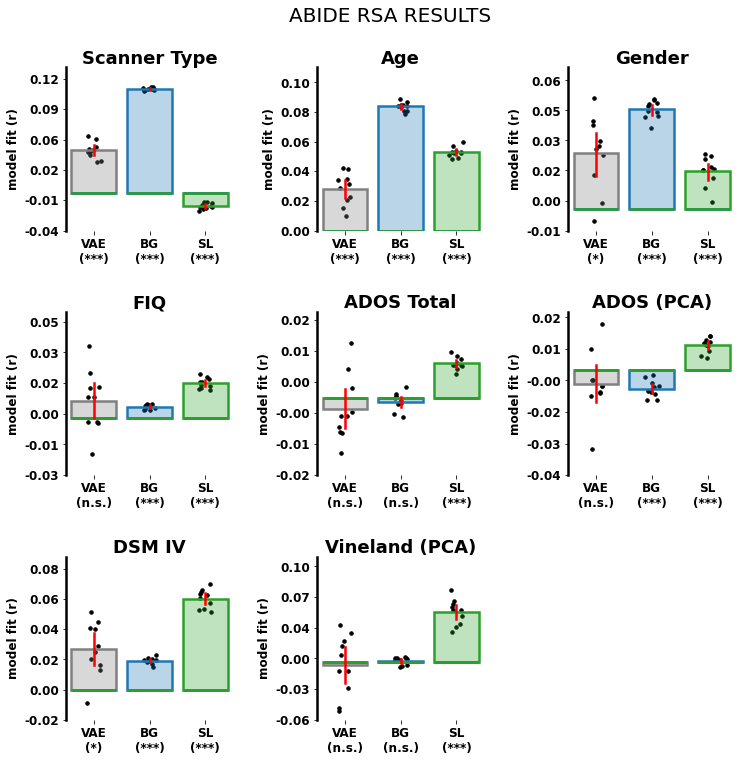

In [15]:
# PLOT ABIDE RSAs
#keys = ['ADOS_Total','ADOS_Social','DSMIVTR','AgeAtScan','Sex','ScannerID','ScanSiteID','FIQ','ADOS_PCA','ADI_PCA','Vineland_PCA',  'WISC_PCA']
keys = ['ScannerID','AgeAtScan','Sex','FIQ','ADOS_Total','ADOS_PCA','DSMIVTR','Vineland_PCA']
titles = ['Scanner Type','Age','Gender','FIQ','ADOS Total','ADOS (PCA)','DSM IV','Vineland (PCA)']


ncols = 3
nrows = int(np.ceil(len(keys)/3))

plt.figure(figsize=np.array((ncols,nrows))*4)

for i,key in enumerate(keys):
    ax = plt.subplot(nrows,ncols,i+1)
    plot_nice_bar(key,rsa_results,
                  ax=ax,figsize=None,
                  dpi=300,fontsize=12,
                  fontsize_star=12,
                  fontweight='bold',
                  line_width=2.5,
                  marker_size=12,title=titles[i])
    
plt.subplots_adjust(
    left=None,
    bottom=None,
    right=None,
    top=None,
    wspace=.5,
    hspace=.5)

plt.suptitle('ABIDE RSA RESULTS',fontsize=20,y=.95);

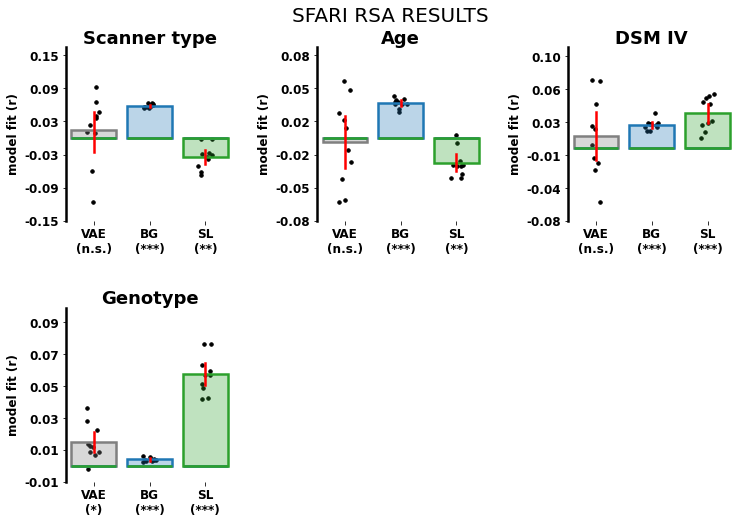

In [16]:
# PLOT SFARI RSAs
keys = ['ord_scanner','age_years','ord_diagnosis','ord_gene']
titles = ['Scanner type','Age','DSM IV','Genotype']

ncols = 3
nrows = int(np.ceil(len(keys)/3))

plt.figure(figsize=np.array((ncols,nrows))*4)

for i,key in enumerate(keys):
    ax = plt.subplot(nrows,ncols,i+1)
    plot_nice_bar(key,rsa_results,
                  ax=ax,figsize=None,
                  dpi=300,fontsize=12,
                  fontsize_star=12,
                  fontweight='bold',
                  line_width=2.5,
                  marker_size=12,title=titles[i])
    
plt.subplots_adjust(
    left=None,
    bottom=None,
    right=None,
    top=None,
    wspace=.5,
    hspace=.5)

plt.suptitle('SFARI RSA RESULTS',fontsize=20,y=.95);

# T-TABLE

In [17]:
from scipy import stats as stats
keys = list(rsa_results.keys())
columns = ['key','VAE>0','BG>0','SL>0','SL>VAE','BG>VAE','SL>BG','BG>SL']
t_table = pd.DataFrame(np.zeros((len(keys),len(columns))),columns=columns)
t_table.shape

(20, 8)

In [18]:
def make_tstatement(vec,t,p,df,delta=False):
    if p < .001:
        t_statement = f'$\\tau$ = {vec.mean():.2f}, t({dg_f}) = {t:.2f}, p $<$ .001'
        
    else:    
        t_statement = f'$\\tau$ = {vec.mean():.2f}, t({dg_f}) = {t:.2f}, p = {p:.3f}'

    if delta==True:
        t_statement = t_statement.replace('$\\tau$','$\\Delta\\tau$')
    return t_statement

In [19]:
keys = ['ScannerID','AgeAtScan','Sex','FIQ','ADOS_Total','ADOS_PCA','DSMIVTR','Vineland_PCA','ord_scanner','age_years','ord_diagnosis','ord_gene']

In [26]:
key = keys[0]

for i,key in enumerate(keys):
    #print(f'{key} / {i}')
    datum = rsa_results[key]
    dg_f = datum.shape[0]-1
    t_table['key'][i] = key
    
    t,p = stats.ttest_1samp(datum[:,0],0)
    t_table['VAE>0'][i] = make_tstatement(datum[:,0],t,p,df)
    #print(make_tstatement(t,p,df))

    t,p = stats.ttest_1samp(datum[:,1],0)
    t_table['BG>0'][i] = make_tstatement(datum[:,1],t,p,df)

    t,p = stats.ttest_1samp(datum[:,2],0)
    t_table['SL>0'][i] = make_tstatement(datum[:,2],t,p,df)

    t,p = stats.ttest_rel(datum[:,2],datum[:,0])
    t_table['SL>VAE'][i] = make_tstatement(datum[:,2]-datum[:,0],t,p,df,delta=True)

    t,p = stats.ttest_rel(datum[:,1],datum[:,0])
    t_table['BG>VAE'][i] = make_tstatement(datum[:,1]-datum[:,0],t,p,df,delta=True)
    #print(make_tstatement(t,p,df))

    t,p = stats.ttest_rel(datum[:,2],datum[:,1])
    t_table['SL>BG'][i] = make_tstatement(datum[:,2]-datum[:,1],t,p,df,delta=True)
    
    t,p = stats.ttest_rel(datum[:,1],datum[:,2])
    t_table['BG>SL'][i] = make_tstatement(datum[:,1]-datum[:,2],t,p,df,delta=True)
    
print(len(t_table))

20


In [27]:
t_table.head(11)

,key,VAE>0,BG>0,SL>0,SL>VAE,BG>VAE,SL>BG,BG>SL
0,ScannerID,"$\tau$ = 0.04, t(9) = 16.29, p $<$ .001","$\tau$ = 0.11, t(9) = 253.01, p $<$ .001","$\tau$ = -0.01, t(9) = -14.16, p $<$ .001","$\Delta\tau$ = -0.06, t(9) = -19.73, p $<$ .001","$\Delta\tau$ = 0.06, t(9) = 22.89, p $<$ .001","$\Delta\tau$ = -0.12, t(9) = -124.83, p $<$ .001","$\Delta\tau$ = 0.12, t(9) = 124.83, p $<$ .001"
1,AgeAtScan,"$\tau$ = 0.03, t(9) = 8.27, p $<$ .001","$\tau$ = 0.08, t(9) = 89.29, p $<$ .001","$\tau$ = 0.05, t(9) = 48.60, p $<$ .001","$\Delta\tau$ = 0.02, t(9) = 6.16, p $<$ .001","$\Delta\tau$ = 0.06, t(9) = 15.23, p $<$ .001","$\Delta\tau$ = -0.03, t(9) = -24.11, p $<$ .001","$\Delta\tau$ = 0.03, t(9) = 24.11, p $<$ .001"
2,Sex,"$\tau$ = 0.03, t(9) = 4.71, p = 0.001","$\tau$ = 0.05, t(9) = 35.34, p $<$ .001","$\tau$ = 0.02, t(9) = 8.13, p $<$ .001","$\Delta\tau$ = -0.01, t(9) = -1.37, p = 0.203","$\Delta\tau$ = 0.02, t(9) = 3.07, p = 0.013","$\Delta\tau$ = -0.03, t(9) = -11.90, p $<$ .001","$\Delta\tau$ = 0.03, t(9) = 11.90, p $<$ .001"
3,FIQ,"$\tau$ = 0.01, t(9) = 1.74, p = 0.116","$\tau$ = 0.01, t(9) = 15.57, p $<$ .001","$\tau$ = 0.02, t(9) = 20.22, p $<$ .001","$\Delta\tau$ = 0.01, t(9) = 1.87, p = 0.094","$\Delta\tau$ = -0.00, t(9) = -0.61, p = 0.554","$\Delta\tau$ = 0.01, t(9) = 12.86, p $<$ .001","$\Delta\tau$ = -0.01, t(9) = -12.86, p $<$ .001"
4,ADOS_Total,"$\tau$ = -0.00, t(9) = -1.08, p = 0.310","$\tau$ = -0.00, t(9) = -1.50, p = 0.167","$\tau$ = 0.01, t(9) = 16.85, p $<$ .001","$\Delta\tau$ = 0.01, t(9) = 4.40, p = 0.002","$\Delta\tau$ = 0.00, t(9) = 0.64, p = 0.536","$\Delta\tau$ = 0.01, t(9) = 11.59, p $<$ .001","$\Delta\tau$ = -0.01, t(9) = -11.59, p $<$ .001"
5,ADOS_PCA,"$\tau$ = -0.01, t(9) = -1.32, p = 0.218","$\tau$ = -0.01, t(9) = -6.92, p $<$ .001","$\tau$ = 0.01, t(9) = 10.47, p $<$ .001","$\Delta\tau$ = 0.01, t(9) = 3.51, p = 0.007","$\Delta\tau$ = -0.00, t(9) = -0.48, p = 0.643","$\Delta\tau$ = 0.02, t(9) = 12.68, p $<$ .001","$\Delta\tau$ = -0.02, t(9) = -12.68, p $<$ .001"
6,DSMIVTR,"$\tau$ = 0.03, t(9) = 4.77, p = 0.001","$\tau$ = 0.02, t(9) = 29.02, p $<$ .001","$\tau$ = 0.06, t(9) = 30.83, p $<$ .001","$\Delta\tau$ = 0.03, t(9) = 4.96, p $<$ .001","$\Delta\tau$ = -0.01, t(9) = -1.38, p = 0.202","$\Delta\tau$ = 0.04, t(9) = 20.04, p $<$ .001","$\Delta\tau$ = -0.04, t(9) = -20.04, p $<$ .001"
7,Vineland_PCA,"$\tau$ = -0.00, t(9) = -0.29, p = 0.780","$\tau$ = 0.00, t(9) = 1.17, p = 0.270","$\tau$ = 0.05, t(9) = 12.33, p $<$ .001","$\Delta\tau$ = 0.06, t(9) = 5.05, p $<$ .001","$\Delta\tau$ = 0.00, t(9) = 0.42, p = 0.681","$\Delta\tau$ = 0.05, t(9) = 10.46, p $<$ .001","$\Delta\tau$ = -0.05, t(9) = -10.46, p $<$ .001"
8,ord_scanner,"$\tau$ = 0.01, t(9) = 0.77, p = 0.461","$\tau$ = 0.06, t(9) = 49.79, p $<$ .001","$\tau$ = -0.03, t(9) = -4.89, p $<$ .001","$\Delta\tau$ = -0.05, t(9) = -2.35, p = 0.043","$\Delta\tau$ = 0.04, t(9) = 2.25, p = 0.051","$\Delta\tau$ = -0.09, t(9) = -12.81, p $<$ .001","$\Delta\tau$ = 0.09, t(9) = 12.81, p $<$ .001"
9,age_years,"$\tau$ = -0.00, t(9) = -0.33, p = 0.752","$\tau$ = 0.03, t(9) = 23.80, p $<$ .001","$\tau$ = -0.02, t(9) = -5.70, p $<$ .001","$\Delta\tau$ = -0.02, t(9) = -1.39, p = 0.198","$\Delta\tau$ = 0.04, t(9) = 2.84, p = 0.019","$\Delta\tau$ = -0.06, t(9) = -15.09, p $<$ .001","$\Delta\tau$ = 0.06, t(9) = 15.09, p $<$ .001"
